In [3]:
import findspark
import pandas as pd
findspark.init()
findspark.find()

from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
# spark = SparkSession.builder.master("local[*]").getOrCreate()
# spark.conf.set("sparl.sql.repl.eagerEval.enabled", True)
from pyspark.sql.functions import col, isnan, when, count,rand
from pyspark.sql import SparkSession

from pyspark.sql.functions import col, hour, when, unix_timestamp, round as spark_round
from pyspark.sql.types import IntegerType
import numpy as np
from pyspark.sql.functions import col, unix_timestamp
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml import Pipeline


spark = SparkSession.builder \
    .appName("YellowTripDataAnalysis") \
    .master("local[*]") \
    .getOrCreate()

spark

In [4]:
# Lectura de informacion
df = spark.read.option("header", True).option("inferSchema", True).csv("../data/yellow_tripdata/yellow_tripdata_2015-01.csv")
print(f"Número de filas: {df.count()}")
print(f"Número de columnas: {df.columns}")
df.show(5)
# display(df)

Número de filas: 12748986
Número de columnas: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+-----------

In [5]:
# Generamos un diccionario con los factores de caracterización
charact_factor = {
    "passenger_count": 1e10,
    "trip_distance": 2.5,
    "payment_type": 3,
    "total_amount": 3,
    "tpep_pickup_datetime": 1e10,
    "tpep_dropoff_datetime": 1e10,
}

# Obtenemos una muestra del 5% de los datos originales
sample = df.select(list(charact_factor.keys())).sample(False, 0.05, seed=42)

In [6]:
# Copiamos el DataFrame original a otro DataFrame
df_sample = sample.select("*")

# Se eliminan las filas con valores nulos
df_sample = df_sample.dropna()

# Se crea la columna trip_duration
df_sample = df_sample.withColumn(
    "trip_duration",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60,
)

# Se agrega la columna trip_duration al diccionario charact_factor
charact_factor['trip_duration'] = 2

# Se extraen las horas de las columnas tpep_pickup_datetime y tpep_dropoff_datetime
df_sample = df_sample.withColumn("tpep_pickup_datetime", hour("tpep_pickup_datetime"))
df_sample = df_sample.withColumn("tpep_dropoff_datetime", hour("tpep_dropoff_datetime"))

# Se eliminan los valores negativos y ceros de las columnas trip_distance, 
# total_amount, passenger_count y trip_duration
for colname in ["trip_distance", "total_amount", "passenger_count", "trip_duration"]:
    df_sample = df_sample.filter(col(colname) > 0)

# Se crea la columna trip_distance_bind
df_sample = df_sample.withColumn(
    "trip_distance_bind",
    when(col("trip_distance") <= 3.0, 1)
    .when((col("trip_distance") > 3.0) & (col("trip_distance") <= 10.0), 2)
    .when(col("trip_distance") > 10.0, 3)
)

# Se crea la columna total_amount_bind
df_sample = df_sample.withColumn(
    "total_amount_bind",
    when(col("total_amount") <= 10.0, 1)
    .when((col("total_amount") > 10.0) & (col("total_amount") <= 20.0), 2)
    .when(col("total_amount") > 20.0, 3)
)

# Se crea la columna passenger_count_bind
df_sample = df_sample.withColumn(
    "passenger_count_bind",
    when(col("passenger_count") <= 2.0, 1)
    .when((col("passenger_count") > 2.0) & (col("passenger_count") <= 6.0), 2)
)

# Se crea la columna trip_duration_bind
df_sample = df_sample.withColumn(
    "trip_duration_bind",
    when(col("trip_duration") <= 10.0, 1)
    .when((col("trip_duration") > 10.0) & (col("trip_duration") <= 20.0), 2)
    .when(col("trip_duration") > 20.0, 3)
)

# Se crea la columna payment_type_bind
df_sample = df_sample.withColumn(
    "payment_type_bind",
    when(col("payment_type") == 1.0, 1)
    .when((col("payment_type") > 1.0) & (col("payment_type") <= 6.0), 2)
)

# Se vuelven a eliminar las filas con valores nulos
df_sample = df_sample.dropna()

# Se convierten las columnas binned a tipo Integer
for binned_col in [
    "trip_distance_bind",
    "trip_duration_bind",
    "total_amount_bind",
    "passenger_count_bind",
    "payment_type_bind",
]:
    df_sample = df_sample.withColumn(binned_col, col(binned_col).cast(IntegerType()))

# Se eliminan los outliers de las columnas numéricas
for col_name, factor in charact_factor.items():
    quantiles = df_sample.approxQuantile(col_name, [0.25, 0.75], 0.0)
    q1, q3 = quantiles
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    df_sample = df_sample.filter((col(col_name) >= lower) & (col(col_name) <= upper))


In [7]:
# Importa las librerías necesarias
from itertools import product
from pyspark.sql.functions import col

# Iteraciones de los valores binned
iterations = {
    "total_amount_bind": [1, 2, 3],
    "trip_distance_bind": [1, 2, 3],
    "payment_type_bind": [1, 2],
    "passenger_count_bind": [1, 2]
}

# Número total de filas
total_rows = df_sample.count()

# Extracción de las claves y valores del diccionario
keys = list(iterations.keys())
values = list(iterations.values())

# Crear todas las combinaciones posibles de los valores
combinations = list(product(*values))

# Número de iteración
iter_num = 1

# Suma total de proporciones
total_proportion = 0

# Iterar sobre cada combinación
for comb in combinations:
    # Construir el filtro dinámicamente
    condition = (col(keys[0]) == comb[0])
    for i in range(1, len(keys)):
        condition &= (col(keys[i]) == comb[i])
    
    # Aplicar el filtro
    filtered_rows = df_sample.filter(condition)
    
    # Contar y calcular proporción
    count = filtered_rows.count()
    proportion = count / total_rows if total_rows != 0 else 0

    print(f"Combinación: {comb} / iteración: {iter_num}, Proporción: {proportion:.4f}")
    
    iter_num += 1
    total_proportion += proportion

# Mostrar proporción total
print(f"Proporción total: {total_proportion:.4f}")


Combinación: (1, 1, 1, 1) / iteración: 1, Proporción: 0.1930


Combinación: (1, 1, 1, 2) / iteración: 2, Proporción: 0.0327


Combinación: (1, 1, 2, 1) / iteración: 3, Proporción: 0.1954


Combinación: (1, 1, 2, 2) / iteración: 4, Proporción: 0.0362


Combinación: (1, 2, 1, 1) / iteración: 5, Proporción: 0.0000


Combinación: (1, 2, 1, 2) / iteración: 6, Proporción: 0.0000


Combinación: (1, 2, 2, 1) / iteración: 7, Proporción: 0.0001


Combinación: (1, 2, 2, 2) / iteración: 8, Proporción: 0.0000


Combinación: (1, 3, 1, 1) / iteración: 9, Proporción: 0.0000


Combinación: (1, 3, 1, 2) / iteración: 10, Proporción: 0.0000


Combinación: (1, 3, 2, 1) / iteración: 11, Proporción: 0.0000


Combinación: (1, 3, 2, 2) / iteración: 12, Proporción: 0.0000


Combinación: (2, 1, 1, 1) / iteración: 13, Proporción: 0.2218


Combinación: (2, 1, 1, 2) / iteración: 14, Proporción: 0.0384


Combinación: (2, 1, 2, 1) / iteración: 15, Proporción: 0.0778


Combinación: (2, 1, 2, 2) / iteración: 16, Proporción: 0.0154


Combinación: (2, 2, 1, 1) / iteración: 17, Proporción: 0.0463


Combinación: (2, 2, 1, 2) / iteración: 18, Proporción: 0.0084


Combinación: (2, 2, 2, 1) / iteración: 19, Proporción: 0.0366


Combinación: (2, 2, 2, 2) / iteración: 20, Proporción: 0.0074


Combinación: (2, 3, 1, 1) / iteración: 21, Proporción: 0.0000


Combinación: (2, 3, 1, 2) / iteración: 22, Proporción: 0.0000


Combinación: (2, 3, 2, 1) / iteración: 23, Proporción: 0.0000


Combinación: (2, 3, 2, 2) / iteración: 24, Proporción: 0.0000


Combinación: (3, 1, 1, 1) / iteración: 25, Proporción: 0.0038


Combinación: (3, 1, 1, 2) / iteración: 26, Proporción: 0.0006


Combinación: (3, 1, 2, 1) / iteración: 27, Proporción: 0.0001


Combinación: (3, 1, 2, 2) / iteración: 28, Proporción: 0.0000


Combinación: (3, 2, 1, 1) / iteración: 29, Proporción: 0.0586


Combinación: (3, 2, 1, 2) / iteración: 30, Proporción: 0.0102


Combinación: (3, 2, 2, 1) / iteración: 31, Proporción: 0.0141


Combinación: (3, 2, 2, 2) / iteración: 32, Proporción: 0.0029


Combinación: (3, 3, 1, 1) / iteración: 33, Proporción: 0.0000


Combinación: (3, 3, 1, 2) / iteración: 34, Proporción: 0.0000


Combinación: (3, 3, 2, 1) / iteración: 35, Proporción: 0.0000


Combinación: (3, 3, 2, 2) / iteración: 36, Proporción: 0.0000
Proporción total: 1.0000


In [8]:

# Establece los rangos para las columnas
total_amount_bind = [0.0, 10.0, 20.0, 100.0]
trip_distance_bind = [0.0, 3.0, 10.0, 100.0]
payment_type_bind = [0.0, 1.0, 6.0]
passenger_count_bind = [0.0, 2.0, 6.0]

# Crea listas para almacenar los rangos de cada columna
total_amount_bind_ranges = []
trip_distance_bind_ranges = []
payment_type_bind_ranges = []
passenger_count_bind_ranges = []

# Crea los rangos para cada columna
for i in range(len(total_amount_bind) - 1):
    total_amount_bind_ranges.append((total_amount_bind[i], total_amount_bind[i + 1]))
    
for i in range(len(trip_distance_bind) - 1):
    trip_distance_bind_ranges.append((trip_distance_bind[i], trip_distance_bind[i + 1]))
    
for i in range(len(payment_type_bind) - 1):
    payment_type_bind_ranges.append((payment_type_bind[i], payment_type_bind[i + 1]))
    
for i in range(len(passenger_count_bind) - 1):
    passenger_count_bind_ranges.append((passenger_count_bind[i], passenger_count_bind[i + 1]))

# Imprime los rangos de cada columna
print("Total amount bind ranges: ", total_amount_bind_ranges)
print("Trip distance bind ranges: ", trip_distance_bind_ranges)
print("Payment type bind ranges: ", payment_type_bind_ranges)
print("Passenger count bind ranges: ", passenger_count_bind_ranges)

# Crea todas las combinaciones posibles de los rangos
combinations = list(product(total_amount_bind_ranges, trip_distance_bind_ranges, payment_type_bind_ranges, passenger_count_bind_ranges))

# Imprime las combinaciones
print("Combinations: ", combinations)

Total amount bind ranges:  [(0.0, 10.0), (10.0, 20.0), (20.0, 100.0)]
Trip distance bind ranges:  [(0.0, 3.0), (3.0, 10.0), (10.0, 100.0)]
Payment type bind ranges:  [(0.0, 1.0), (1.0, 6.0)]
Passenger count bind ranges:  [(0.0, 2.0), (2.0, 6.0)]
Combinations:  [((0.0, 10.0), (0.0, 3.0), (0.0, 1.0), (0.0, 2.0)), ((0.0, 10.0), (0.0, 3.0), (0.0, 1.0), (2.0, 6.0)), ((0.0, 10.0), (0.0, 3.0), (1.0, 6.0), (0.0, 2.0)), ((0.0, 10.0), (0.0, 3.0), (1.0, 6.0), (2.0, 6.0)), ((0.0, 10.0), (3.0, 10.0), (0.0, 1.0), (0.0, 2.0)), ((0.0, 10.0), (3.0, 10.0), (0.0, 1.0), (2.0, 6.0)), ((0.0, 10.0), (3.0, 10.0), (1.0, 6.0), (0.0, 2.0)), ((0.0, 10.0), (3.0, 10.0), (1.0, 6.0), (2.0, 6.0)), ((0.0, 10.0), (10.0, 100.0), (0.0, 1.0), (0.0, 2.0)), ((0.0, 10.0), (10.0, 100.0), (0.0, 1.0), (2.0, 6.0)), ((0.0, 10.0), (10.0, 100.0), (1.0, 6.0), (0.0, 2.0)), ((0.0, 10.0), (10.0, 100.0), (1.0, 6.0), (2.0, 6.0)), ((10.0, 20.0), (0.0, 3.0), (0.0, 1.0), (0.0, 2.0)), ((10.0, 20.0), (0.0, 3.0), (0.0, 1.0), (2.0, 6.0)), ((10.0

In [9]:
# Importando librerías necesarias
from pyspark.sql.types import StructType, StructField, IntegerType

# Conteo de filas del DataFrame original
total_rows = df.count()

# Variables para almacenar los resultados
subsets = []
iter_num = 1
total_proportion = 0
total_proportion_in_new_df = 0
df_accumulated = None

# Iterar sobre cada combinación
for comb in combinations:
    filtered_rows = df.filter(
        (col("total_amount") > comb[0][0]) & (col("total_amount") <= comb[0][1]) &
        (col("trip_distance") > comb[1][0]) & (col("trip_distance") <= comb[1][1]) &
        (col("payment_type") > comb[2][0]) & (col("payment_type") <= comb[2][1]) &
        (col("passenger_count") > comb[3][0]) & (col("passenger_count") <= comb[3][1])
    )
    subsets.append(filtered_rows)
    
    # Calcular la proporción de filas filtradas respecto al total
    prop = filtered_rows.count() / total_rows
    total_proportion += prop
    print(f"Porcentaje: {total_proportion:.2f} / combinación: {comb} / iteración: {iter_num} / proporción: {prop:.4f}")
    iter_num += 1

    # Si la proporción es mayor que 0.05, tomar el 40% de las filas
    if prop > 0.05:

        # Tomar el 40% de las filas filtradas
        filtered_rows_fraction = filtered_rows.sample(withReplacement=False, fraction=0.4, seed=42)

        if df_accumulated is None:
            df_accumulated = filtered_rows_fraction
        else:
            df_accumulated = df_accumulated.union(filtered_rows_fraction)

        # Guarda la proporción de filas filtradas respecto al total
        total_proportion_in_new_df += filtered_rows.count() / total_rows

        print("Combination accepted")
    
# Imprime resultados
print(f"Proporción total: {total_proportion:.4f}")
print(f"Proporción total en el nuevo DataFrame: {total_proportion_in_new_df:.4f}")

Porcentaje: 0.18 / combinación: ((0.0, 10.0), (0.0, 3.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 1 / proporción: 0.1753


Combination accepted


Porcentaje: 0.21 / combinación: ((0.0, 10.0), (0.0, 3.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 2 / proporción: 0.0298


Porcentaje: 0.38 / combinación: ((0.0, 10.0), (0.0, 3.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 3 / proporción: 0.1786


Combination accepted


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (0.0, 3.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 4 / proporción: 0.0330


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (3.0, 10.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 5 / proporción: 0.0000


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (3.0, 10.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 6 / proporción: 0.0000


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (3.0, 10.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 7 / proporción: 0.0002


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (3.0, 10.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 8 / proporción: 0.0000


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (10.0, 100.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 9 / proporción: 0.0000


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (10.0, 100.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 10 / proporción: 0.0000


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (10.0, 100.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 11 / proporción: 0.0001


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (10.0, 100.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 12 / proporción: 0.0000


Porcentaje: 0.62 / combinación: ((10.0, 20.0), (0.0, 3.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 13 / proporción: 0.2025


Combination accepted


Porcentaje: 0.65 / combinación: ((10.0, 20.0), (0.0, 3.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 14 / proporción: 0.0346


Porcentaje: 0.72 / combinación: ((10.0, 20.0), (0.0, 3.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 15 / proporción: 0.0707


Combination accepted


Porcentaje: 0.74 / combinación: ((10.0, 20.0), (0.0, 3.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 16 / proporción: 0.0139


Porcentaje: 0.78 / combinación: ((10.0, 20.0), (3.0, 10.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 17 / proporción: 0.0425


Porcentaje: 0.79 / combinación: ((10.0, 20.0), (3.0, 10.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 18 / proporción: 0.0078


Porcentaje: 0.82 / combinación: ((10.0, 20.0), (3.0, 10.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 19 / proporción: 0.0333


Porcentaje: 0.83 / combinación: ((10.0, 20.0), (3.0, 10.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 20 / proporción: 0.0068


Porcentaje: 0.83 / combinación: ((10.0, 20.0), (10.0, 100.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 21 / proporción: 0.0000


Porcentaje: 0.83 / combinación: ((10.0, 20.0), (10.0, 100.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 22 / proporción: 0.0000


Porcentaje: 0.83 / combinación: ((10.0, 20.0), (10.0, 100.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 23 / proporción: 0.0000


Porcentaje: 0.83 / combinación: ((10.0, 20.0), (10.0, 100.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 24 / proporción: 0.0000


Porcentaje: 0.83 / combinación: ((20.0, 100.0), (0.0, 3.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 25 / proporción: 0.0044


Porcentaje: 0.83 / combinación: ((20.0, 100.0), (0.0, 3.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 26 / proporción: 0.0007


Porcentaje: 0.83 / combinación: ((20.0, 100.0), (0.0, 3.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 27 / proporción: 0.0006


Porcentaje: 0.83 / combinación: ((20.0, 100.0), (0.0, 3.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 28 / proporción: 0.0001


Porcentaje: 0.91 / combinación: ((20.0, 100.0), (3.0, 10.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 29 / proporción: 0.0740


Combination accepted


Porcentaje: 0.92 / combinación: ((20.0, 100.0), (3.0, 10.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 30 / proporción: 0.0129


Porcentaje: 0.94 / combinación: ((20.0, 100.0), (3.0, 10.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 31 / proporción: 0.0209


Porcentaje: 0.95 / combinación: ((20.0, 100.0), (3.0, 10.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 32 / proporción: 0.0042


Porcentaje: 0.97 / combinación: ((20.0, 100.0), (10.0, 100.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 33 / proporción: 0.0259


Porcentaje: 0.98 / combinación: ((20.0, 100.0), (10.0, 100.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 34 / proporción: 0.0046


Porcentaje: 0.99 / combinación: ((20.0, 100.0), (10.0, 100.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 35 / proporción: 0.0121


Porcentaje: 0.99 / combinación: ((20.0, 100.0), (10.0, 100.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 36 / proporción: 0.0026
Proporción total: 0.9922
Proporción total en el nuevo DataFrame: 0.7011


In [10]:
# Imprime dimensiones del DataFrame acumulado
num_rows_after_dimension_extraction = df_accumulated.count()
num_cols_after_dimension_extraction = len(df_accumulated.columns)
print(f"Número de filas despues de la extración contenida de dimensiones: {num_rows_after_dimension_extraction}")
print(f"Número de columnas despues de la extración contenida de dimensiones: {num_cols_after_dimension_extraction}")

Número de filas despues de la extración contenida de dimensiones: 3582756
Número de columnas despues de la extración contenida de dimensiones: 19


In [11]:
# Eliminar registros con valores nulos en columnas clave

df_clean = df_accumulated.dropna(subset=[
    "trip_distance", "fare_amount", "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude", "payment_type"
])

# Filtrar valores atípicos (e.g., distancias o tarifas <= 0)
df_clean = df_clean.filter(
    (col("trip_distance") > 0) & (col("fare_amount") > 0) & (col("total_amount") > 0)
)

# Calcular duración del viaje en minutos
df_clean = df_clean.withColumn(
    "duration_minutes",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60
)

# # Filtrar duraciones negativas o excesivas
df_clean = df_clean.filter((col("duration_minutes") > 0) & (col("duration_minutes") < 180))

outlier_columns = [
    "tip_amount",
    "duration_minutes"
    ]

# Se eliminan los outliers de las columnas numéricas
for col_name in outlier_columns:
    quantiles = df_clean.approxQuantile(col_name, [0.25, 0.75], 0.0)
    q1, q3 = quantiles
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df_clean = df_clean.filter((col(col_name) >= lower) & (col(col_name) <= upper))

In [12]:
from pyspark.sql.functions import when, concat_ws, col, count as spark_count, sum as spark_sum, round as spark_round

# Binning simplificado con nuevos nombres
df_strat = df_clean \
    .withColumn("amt_bin", when(col("total_amount") < 10, "A").when(col("total_amount") < 20, "B").otherwise("C")) \
    .withColumn("dist_bin", when(col("trip_distance") < 3, "X").when(col("trip_distance") < 10, "Y").otherwise("Z")) \
    .withColumn("pay_bin", when(col("payment_type") == 1, "E").otherwise("F")) \
    .withColumn("pass_bin", when(col("passenger_count") <= 2, "L").otherwise("M"))

# Crear clave de estrato combinando los bins
df_strat = df_strat.withColumn("grupo", concat_ws("-", "amt_bin", "dist_bin", "pay_bin", "pass_bin"))

# Conteo total
total_registros = df_strat.count()

# Conteo y proporción por grupo
conteo_grupo = df_strat.groupBy("grupo").agg(
    spark_count("*").alias("total"),
).withColumn("porc", col("total") / total_registros)

# Tamaño de muestra total (10%)
tam_muestra = int(total_registros * 0.1)

# Cálculo de tamaño por grupo
conteo_grupo = conteo_grupo.withColumn("muestra", spark_round(col("porc") * tam_muestra).cast("int"))

# Convertir a diccionarios para el muestreo
grupo_total_dict = {row["grupo"]: row["total"] for row in conteo_grupo.collect()}
grupo_muestra_dict = {row["grupo"]: row["muestra"] for row in conteo_grupo.collect()}

# Calcular fracciones de muestreo por grupo
fracciones = {
    grupo: grupo_muestra_dict[grupo] / grupo_total_dict[grupo]
    for grupo in grupo_muestra_dict
}

# Aplicar muestreo estratificado
muestra_df = df_strat.sampleBy("grupo", fractions=fracciones, seed=123)

# Verificación final
total_M = muestra_df.count()
total_Mi = muestra_df.groupBy("grupo").agg(spark_sum("grupo").alias("suma")).count()

print(f"Total registros en M: {total_M}")
print(f"Suma por subgrupos Mi: {total_Mi}")


Total registros en M: 335321
Suma por subgrupos Mi: 10


In [13]:
from functools import reduce

# Proporciones de partición
prop_train, prop_test = 0.8, 0.2

# Obtener lista de grupos únicos
grupos = [row["grupo"] for row in muestra_df.select("grupo").distinct().collect()]

# Particionar por grupo y acumular
particiones = [muestra_df.filter(col("grupo") == g).randomSplit([prop_train, prop_test], seed=42) for g in grupos]

# Separar listas de entrenamiento y prueba
conjuntos_entrenamiento = [par[0] for par in particiones]
conjuntos_prueba = [par[1] for par in particiones]

# Unir todos los subconjuntos
df_train = reduce(lambda a, b: a.union(b), conjuntos_entrenamiento)
df_test = reduce(lambda a, b: a.union(b), conjuntos_prueba)

# Mostrar tamaños
print(f"Conjunto de entrenamiento: {df_train.count()} registros")
print(f"Conjunto de prueba: {df_test.count()} registros")


25/06/16 20:53:07 WARN DAGScheduler: Broadcasting large task binary with size 1683.3 KiB


Conjunto de entrenamiento: 268097 registros


25/06/16 20:56:12 WARN DAGScheduler: Broadcasting large task binary with size 1683.3 KiB


Conjunto de prueba: 67224 registros


In [14]:
df_train.show(5)

25/06/16 20:59:18 WARN DAGScheduler: Broadcasting large task binary with size 1801.5 KiB


+--------+--------------------+---------------------+---------------+-------------+------------------+-----------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-----------------+-------+--------+-------+--------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|  pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount| duration_minutes|amt_bin|dist_bin|pay_bin|pass_bin|  grupo|
+--------+--------------------+---------------------+---------------+-------------+------------------+-----------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-----------------+--

In [15]:
features = ["passenger_count","trip_distance","payment_type","duration_minutes"]
target = "total_amount"
assembler = VectorAssembler(inputCols=features, outputCol="features")
rf = RandomForestRegressor(featuresCol="features", labelCol=target, numTrees=30, maxDepth=5, seed=42)
pipeline = Pipeline(stages=[assembler, rf])
modelo = pipeline.fit(df_train)
preds = modelo.transform(df_test)
rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse").evaluate(preds)
print(f"RMSE base: {rmse:.4f}")

25/06/16 20:59:21 WARN DAGScheduler: Broadcasting large task binary with size 1667.9 KiB
25/06/16 20:59:23 WARN DAGScheduler: Broadcasting large task binary with size 1667.9 KiB
25/06/16 21:02:28 WARN DAGScheduler: Broadcasting large task binary with size 1672.6 KiB
25/06/16 21:05:31 WARN DAGScheduler: Broadcasting large task binary with size 1674.7 KiB
25/06/16 21:08:53 WARN DAGScheduler: Broadcasting large task binary with size 1685.1 KiB
25/06/16 21:08:55 WARN DAGScheduler: Broadcasting large task binary with size 1703.2 KiB
25/06/16 21:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1739.3 KiB
25/06/16 21:09:04 WARN DAGScheduler: Broadcasting large task binary with size 1808.4 KiB
25/06/16 21:09:12 WARN DAGScheduler: Broadcasting large task binary with size 1657.8 KiB


RMSE base: 1.1880


25/06/16 21:12:28 WARN DAGScheduler: Broadcasting large task binary with size 1658.9 KiB


In [16]:
k = 5
df_strat = muestra_df  # usar la muestra estratificada de Actividad 4
df_strat = df_strat.withColumn("rand", rand(seed=42))
folds = []
for i in range(k):
    lower = i / k
    upper = (i + 1) / k
    fold_i = df_strat.filter((col("rand") >= lower) & (col("rand") < upper)).drop("rand")
    folds.append(fold_i)
    print(f"Fold {i+1}: {fold_i.count()} registros")

Fold 1: 67113 registros


Fold 2: 66906 registros


Fold 3: 67134 registros


Fold 4: 67011 registros


Fold 5: 67157 registros


In [17]:
metrics = []
for i in range(k):
    test_i = folds[i]
    # Unir todos los folds excepto el actual
    train_parts = [folds[j] for j in range(k) if j != i]
    train_i = train_parts[0]
    for part in train_parts[1:]:
        train_i = train_i.union(part)
    # Entrenar y evaluar
    model_i = pipeline.fit(train_i)
    preds_i = model_i.transform(test_i)
    rmse_i = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse").evaluate(preds_i)
    metrics.append((i+1, rmse_i))
    print(f"Fold {i+1} RMSE: {rmse_i:.4f}")

Fold 1 RMSE: 1.2348


Fold 2 RMSE: 1.2480


Fold 3 RMSE: 1.2393


Fold 4 RMSE: 1.2122


Fold 5 RMSE: 1.2071


In [18]:
import pandas as pd
df_metrics = pd.DataFrame(metrics, columns=["fold","rmse"])

/tmp/ipykernel_71226/581898985.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df_metrics['rmse'], labels=['RMSE'])


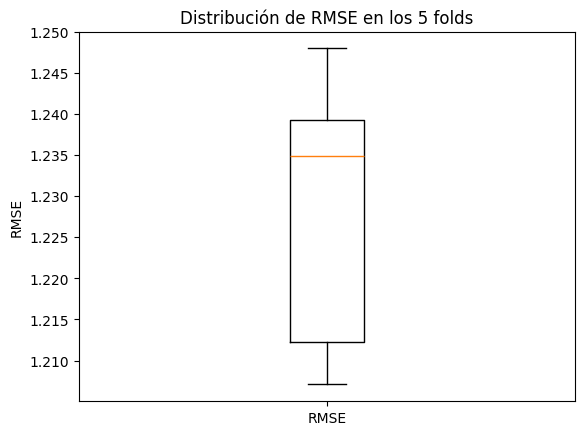

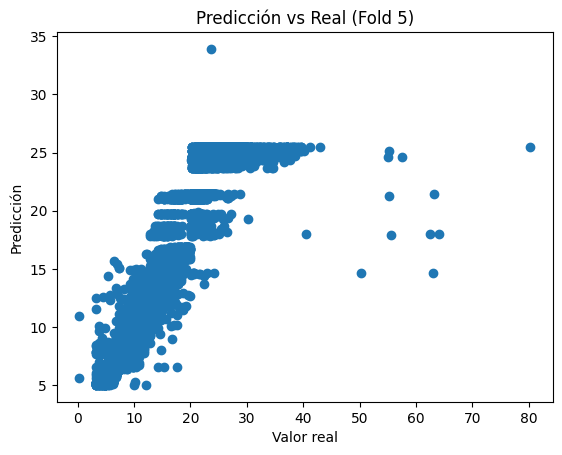

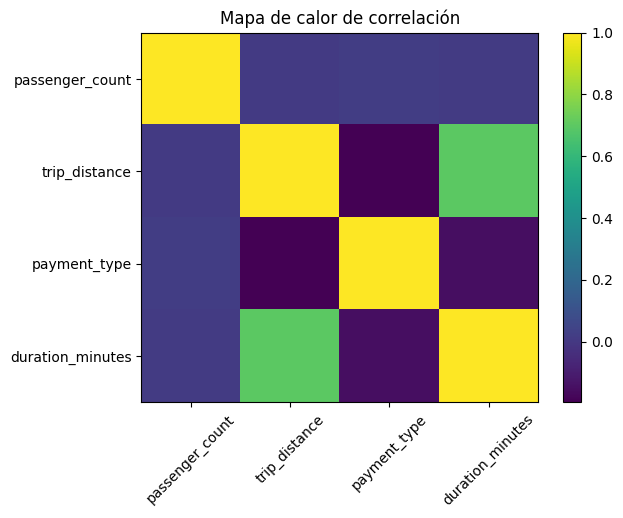

In [19]:
import matplotlib.pyplot as plt

# 1. Boxplot de RMSE por fold
plt.figure()
plt.boxplot(df_metrics['rmse'], labels=['RMSE'])
plt.title('Distribución de RMSE en los 5 folds')
plt.ylabel('RMSE')
plt.show()

# 2. Scatter predicción vs real en el último fold
last_preds = preds_i.select(target, 'prediction').toPandas()
plt.figure()
plt.scatter(last_preds[target], last_preds['prediction'])
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.title('Predicción vs Real (Fold 5)')
plt.show()

# 3. Mapa de calor de correlación de features
corr = pd.DataFrame(df_strat.select(features).toPandas()).corr()
plt.figure()
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(features)), features, rotation=45)
plt.yticks(range(len(features)), features)
plt.title('Mapa de calor de correlación')
plt.show()
